# MSE403 Lab 4 Report - Unsupervised Learning
#### Alex Liu 1007030008

## Introduction
In this lab, by using unsupervised learning method, a phase diagram will be generated from x-ray diffraction datasets for the VO2-Nb2O3 system under different temperatures. There will be two files used in this lab. The first one includes the composition and temperature data for all 352 measure points, and the second one includes the x-ray diffraction data of those measure points.
After basic data processing and visualization, the data will be analyzed by using dimensional reduction technique like principal component analysis (PCA). After that, different clustering techniques will be performed aiming to identify the three regions in the VO2-Nb2O3 phase diagram.


## Coding Section

First, import the required modules and open the file.

In [2]:
import scipy.io as sio
import numpy.matlib as nm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy
import sklearn

In [3]:
df_cmp = pd.read_csv('VO2 - Nb2O3 Composition and temp Combiview.txt', delimiter='\t')  #seperate the data based on tab
df_cmp = df_cmp.dropna(axis=1)


df_xrd = pd.read_csv('VO2 -Nb2O3 XRD Combiview.txt', delimiter='\t')   #read the xrd data
df_xrd = df_xrd.dropna(axis=1)

Generate a composition versus temperature plots for all the measurements.

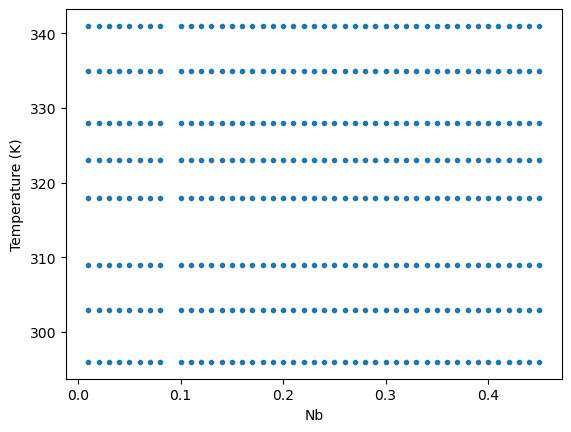

In [4]:
cmp = df_cmp.to_numpy()
xrd = df_xrd.to_numpy()

plt.scatter((100-cmp[:,0])/100,cmp[:,1]+273, marker='.', linestyle='None')

plt.xlabel('Nb')
plt.ylabel('Temperature (K)')
plt.show()   #Convert the y-axis unit to K and x-axis to Nb composition to match the existing phase diagram


Generate x-ray diffraction versus temperature plot for V composition of 99 at.%

Text(0, 0.5, 'Material Points')

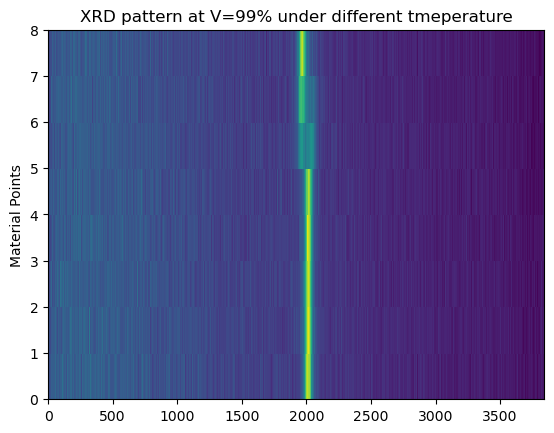

In [5]:
xrd_nnV_in = df_cmp[df_cmp['V']==99].index.values
xrd_nnV = df_xrd.loc[xrd_nnV_in]

temp = df_cmp[df_cmp['V']==99].to_numpy()[:,1]


plt.pcolor(xrd_nnV)
plt.title('XRD pattern at V=99% under different tmeperature')
plt.ylabel('Material Points')




Generate x-ray diffraction versus composition plot for constant temperature of 23 celsius degree.

Text(0, 0.5, 'Material Points')

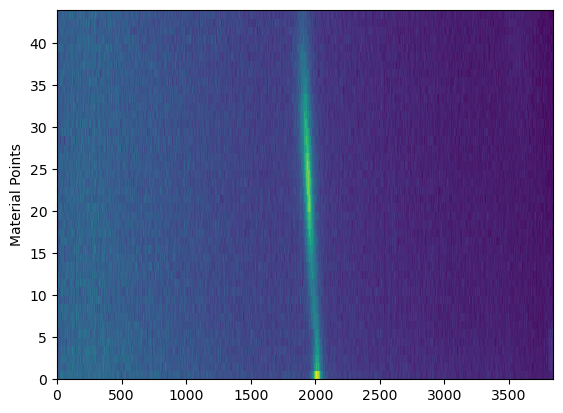

In [6]:
xrd_tt_in = df_cmp[df_cmp['temp']==23].index.values
xrd_tt = df_xrd.loc[xrd_tt_in]

plt.pcolor(xrd_tt)

plt.ylabel('Material Points')


## PCA Analysis of XRD points
First, standardize the data

In [7]:
#Standardize the data
xrd_unstd = xrd.copy()  #save the unstandardized data
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(xrd)

xrd = std.transform(xrd)

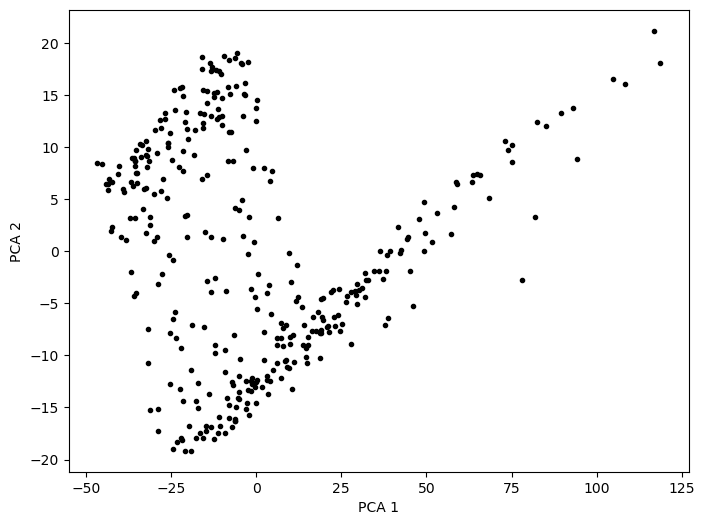

In [8]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

n_components = min(len(xrd[:,0]), len(xrd[0,:]))  #dimension

pca = PCA(n_components=0.8)   #Take the number of principal components that covers 80% of the explained variance (denoising)
pca.fit(xrd)
loading_vectors = pca.components_

explained_variance = pca.explained_variance_ratio_
pos = pca.transform(xrd)    #transform the data to the new variable

plt.figure(4, figsize=(8,6))
plt.plot(pos[:,0],pos[:,1],'k.')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()

Show the effect of denoising by using PCA.
- To better show the effect of denoising, only 60% of the explained variance is kept, while the original PCA analysis uses 80% of the explained variance.

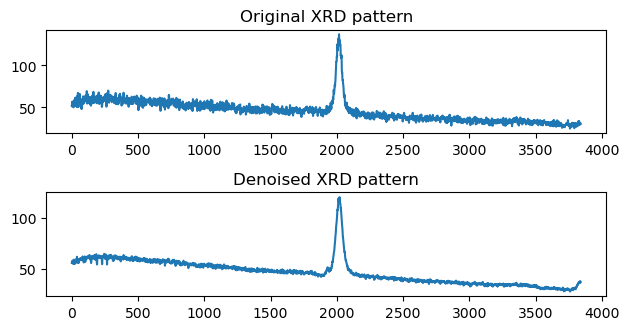

In [23]:
Pca=PCA(n_components=0.6)  #Take the number of principal components that covers 60% of the explained variance
Pca.fit(xrd_unstd)  #use the unstandardized data
pos_unstd = Pca.transform(xrd_unstd)
xrd_denoise = Pca.inverse_transform(pos_unstd)   #inverse transform the data to the original variable
plt.subplot(3,1,1)
plt.plot(xrd_unstd[0,:])
plt.title('Original XRD pattern')
plt.subplot(3,1,2)
plt.plot(xrd_denoise[0,:])
plt.title('Denoised XRD pattern')

plt.tight_layout()

Explained Variance of PCA

In [10]:
print('The explained variance ratio of the first principal component is '+str(round(explained_variance.max(),3)))

The explained variance ratio of the first principal component is 0.25


Plot the explained variance of the principal components

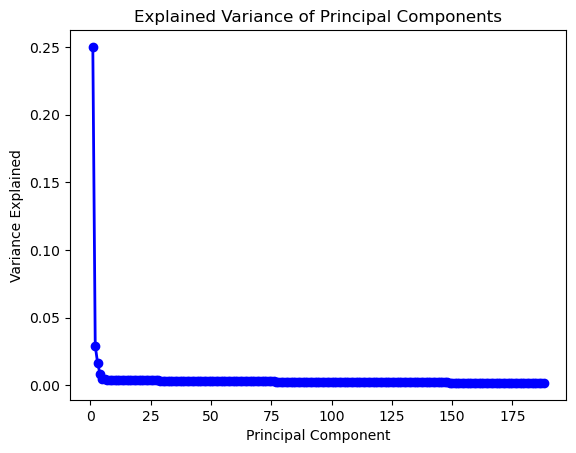

In [11]:
PC_values = np.arange(pca.n_components_) + 1
#print(PC_values)

plt.plot(PC_values, explained_variance, 'o-', linewidth=2, color='blue')

plt.title('Explained Variance of Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

plt.show()

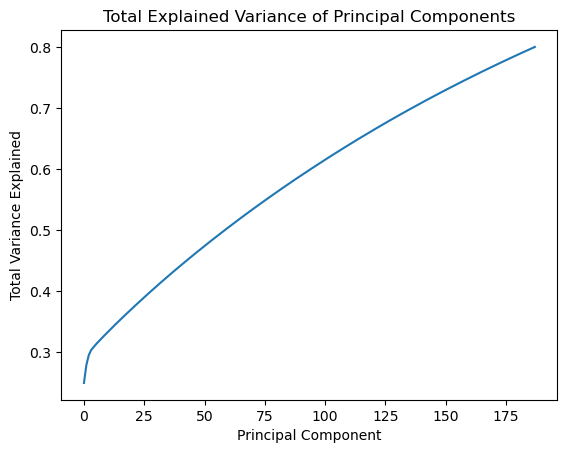

In [12]:
plt.plot(np.cumsum(explained_variance))

plt.title('Total Explained Variance of Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Total Variance Explained')

plt.show()

Plot the diffraction pattern in PCA space with regard to temperature

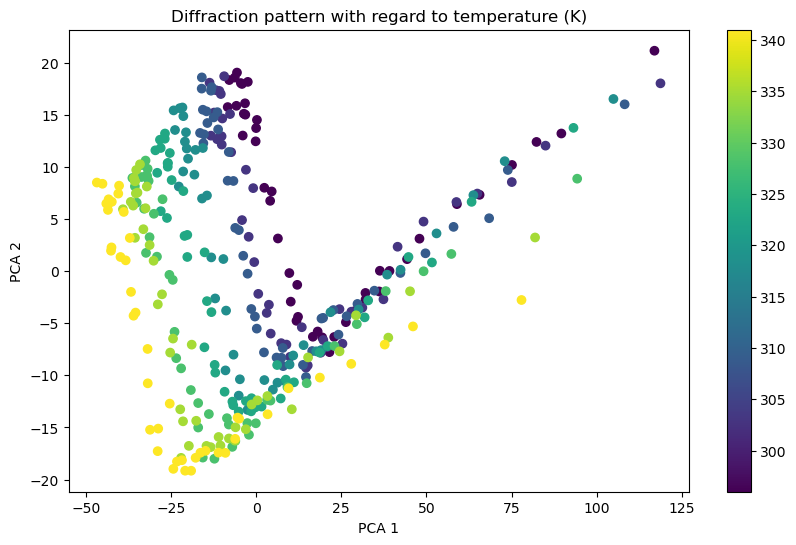

In [13]:
df_pos = pd.DataFrame(pos[:,[0,1]], columns=['PCA 1', 'PCA 2'])
df_pos['V'] = df_cmp['V']
df_pos['temp'] = df_cmp['temp']

plt.figure(4, figsize=(10,6))
plt.scatter(df_pos['PCA 1'], df_pos['PCA 2'], c=df_pos['temp']+273)
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Diffraction pattern with regard to temperature (K)')

plt.show()

Plot the diffraction pattern in PCA space with regard to composition

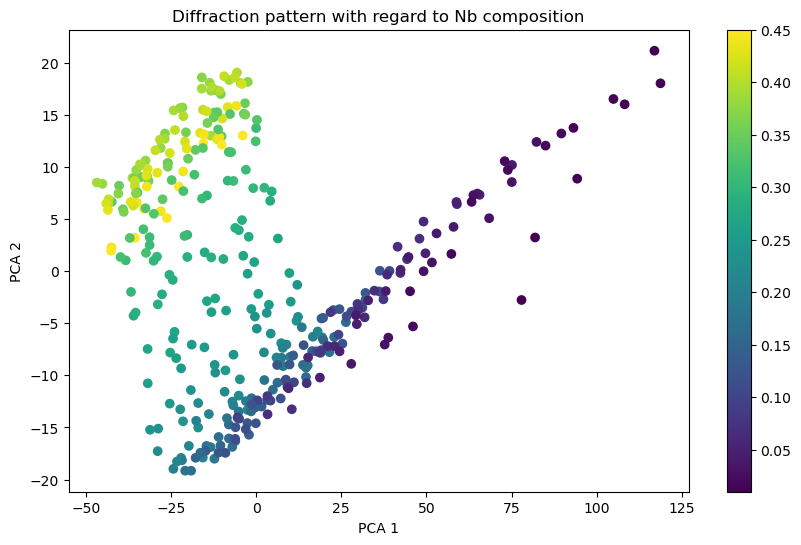

In [14]:
plt.figure(4, figsize=(10,6))
plt.scatter(df_pos['PCA 1'], df_pos['PCA 2'], c=(100-df_pos['V'])/100)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Diffraction pattern with regard to Nb composition')
plt.colorbar()

## Clustering in PCA space
To achieve a result that's the most accurate, different clustering methods, including k means, DBSCAN, and AgglomerativeClustering are used. In DBSCAN, the optimal epsilon is found using the NearestNeighbor module. The AgglomerativeClustering method is considered because it is able to identify 'turns', which fits the plotted 2d data in PCA space. The most accurate clustering approach under this circumstanhce is the AgglomerativeClustering method with standardized data.

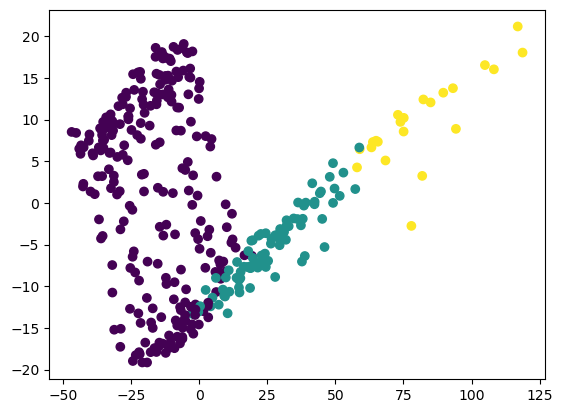

In [15]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3).fit(pos)   #Set the cluster number to 3
L = clustering.labels_
plt.scatter(pos[:,0], pos[:,1], c=L)


Plot the clusters on the phase diagram measurements plot

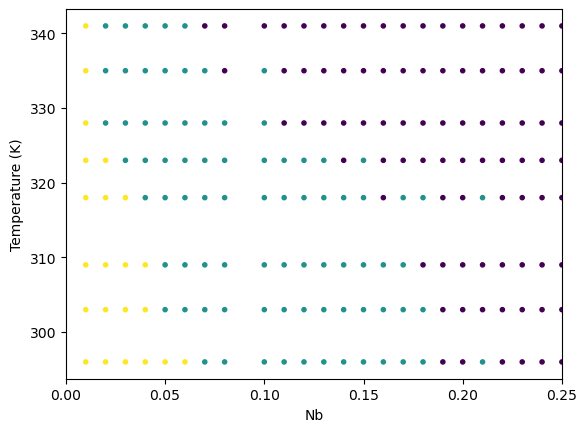

In [16]:
L = pd.DataFrame(L, columns=['Cluster'])  #copilot

plt.scatter((100-cmp[:,0])/100,cmp[:,1]+273, c=L['Cluster'], marker='.', linestyle='None')#
plt.xlim([0, 0.25])  #Using the same scale as the real phase diagram
plt.xlabel('Nb')
plt.ylabel('Temperature (K)')
plt.show()

The yellow, purple, and blue regions represent the monoclinic, tetragonal, and coexistance of both phsaes, respectively.


## Summary
In this lab, the XRD data of Nb-V system at different temperatures is analyzed using unsupervised machine learning methods including PCA and clustering. A phase diagram is generated based on the clustering results. The agglomerative clustering method works the best in this case, while k means method and DBSCAN method do not work as well. This could because agglomerative clustering method is able to identify 'turns' in the data. K means clustering tends to generate clusters with similar sizes, which does not fit the different regions in the phase diagram. The DBSCAN method tends to cluster the data points that are close to each other, ignoring the 'turn' pattern in the data. Besides, the result is more accurate with standardized data compared to the original data. The result is also more accurate after dimensional reduction.
The two major lessons learned from this lab are:
1): Always standardize the data before applying PCA
2): Denoising can be accomplished by applying PCA and only keep the principal components that cover around 80% of the explained variance. Clustering can be applied to the denoised data that might achieve a better result.
A physically plausible explanation for the material "archetypes" of each cluster: The two phase region will have two peaks in the XRD pattern, while the monoclinic phase and the tetragonal phase will have only one peak, located at different angles.